# Econ: Overlapping Generations | Problem set

Alberto Quaini

### Import libraries

In [1]:
import numpy as np
import time
import scipy.optimize as opt
import scipy.linalg as la
import matplotlib.pyplot as plt

### Parameters

In [2]:
beta = 0.96**20               # 20-year discount factor
delta = 1 - (1 - 0.05)**20    # 20-year capital depreciation rate
sigma = 3                     # risk-aversion parameter
A = 1                         # productivity scale parameter
alpha = 0.35                  # capital share of income

## Exercise 2.1

Define 'feasible' function

In [14]:
def feasible(f_params, bvec_guess):
    """
    -------
    inputs: 
    -------
    f_params, tuple = (nvec, A, alpha, delta).
        nvec, array(3,1): labour supply of various generations.
        A, scalar: productivity scale parameter.
        alpha, scalar: capital share of income.
        delta, scalar: 20-year capital depreciation rate.
    bvec_guess, array(2,1): guess of steady-state savings vector.
    --------
    returns:
    --------
    b_cnstr, boolean(2,1): ith entry True if ith bvec_guess 
                           is responsible for any nonnegativity
                           constraint violation in c_cnstr.
    c_cnstr, boolean(3,1): True if c_s <= 0, s=1,2,3.
    K_cnstr, boolean(1,1): True if K <= 0.
    """
    
    K_cnstr = bvec_guess.sum() <= 0
    b_cnstr = np.array([False, False])
    c_cnstr = np.array([False, False, False])
    c = np.zeros((3, 1))
    
    K = bvec_guess.sum()
    L = f_params[0].sum()
    r = f_params[2] * f_params[1] * (L / K)**(1 - f_params[2]) 
    - f_params[3]
    w = (1 - f_params[2]) * f_params[1] * (K / L)**f_params[2]
    c[0] = w * f_params[0][0] - bvec_guess[0]
    c[1] = w * f_params[0][1] + (1 + r) * bvec_guess[1]
    c[2] = w * f_params[0][2] + (1 + r) * bvec_guess[1]
    
    c_cnstr = c <= 0
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[0] = True
        b_cnstr[1] = True
    if c_cnstr[2]:
        b_cnstr[1] = True
    print(b_cnstr)
    print(c_cnstr.T[0])
    print(K_cnstr)
    
    #return b_cnstr, c_cnstr, K_cnstr

In [15]:
nvec = np.array([1, 1, 0.2])
f_params = (nvec, A, alpha, delta)
bvec_guess = np.array([1, 1.2])
print('Test (a):')
feasible(f_params, bvec_guess)
bvec_guess = np.array([0.06, -0.001])
print('---------')
print('Test (b):')
feasible(f_params, bvec_guess)
print('---------')
print('Test (c):')
bvec_guess = np.array([0.1, 0.1])
feasible(f_params, bvec_guess)


Test (a):
[ True False]
[ True False False]
False
---------
Test (b):
[False False]
[False False False]
False
---------
Test (c):
[False False]
[False False False]
False


## Exercise 2.2

In [16]:
def u_prime(c, params):
    """ Compute the derivative of utility function
    """
    
    if c >= 1e-6:
        return c**(-params[1])
    else:
        return 1e6**3

In [17]:
def get_r(b_ss, params):
    """ Compute the steady-state interest rate
    """
    
    arg = params[2].sum() / b_ss.sum()
    return params[5] * params[4] * arg**(1 - params[5]) - params[6]

In [18]:
def get_w(b_ss, params):
    """ Comute the steady-state wage 
    """
    
    arg = b_ss.sum() / params[2].sum()
    return (1 - params[5]) * params[4] * arg**params[5]

In [19]:
def get_EulErr(b_ss, params):
    """ Compute the steady-state Euler equations errors
    """
    
    r_ss = get_r(b_ss, params)
    w_ss = get_w(b_ss, params)
    
    c1_ss = params[2][0] * w_ss - b_ss[0]
    c2_ss = params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1]
    c3_ss = params[2][2] * w_ss + (1 + r_ss) * b_ss[1]
    
    eulerr1_ss = u_prime(c1_ss, params) - params[0] * (1 + r_ss) * u_prime(c2_ss, params)
    eulerr2_ss = u_prime(c2_ss, params) - params[0] * (1 + r_ss) * u_prime(c3_ss, params)
    
    return np.array([eulerr1_ss, eulerr2_ss])    

In [20]:
def plot_c_ss(c_ss):
    x = np.arange(3)
    plt.bar(x, c_ss)
    plt.xticks(x, ('C 1', 'C 2', 'C 3'))
    plt.title('Steady-state consumption')
    plt.show()

In [21]:
def plot_b_ss(b_ss):
    x = np.arange(2)
    plt.bar(x, b_ss)
    plt.xticks(x, ('b 2', 'b 3'))
    plt.title('Steady-state savings')
    plt.show()

In [22]:
def get_ss(params, bvec_guess, ss_graphs = False):
    """
    ------
    inputs
    ------
    params, tuple: ((beta, sigma, nvec, L, A, alpha, delta, SS tol)).
    bvec_guess, array(2,1): guess of steady-state savings vector.
    ss_graphs, boolean: generates a figure of the steady-state 
                        distribution of consump- tion and savings 
                        if it is set to True.
    --------
    outputs:
    --------
    ss_output, dict: dictionary with the steady-state solution values 
                     for the following endogenous objects.
    """
    start_time = time.clock()
    
    result = opt.root(get_EulErr, bvec_guess, args = params, tol = params[7])
    b_ss = np.round(result.x, 5)
    r_ss = np.round(get_r(b_ss, params), 5)
    w_ss = np.round(get_w(b_ss, params), 5)
    
    c1_ss = np.round(params[2][0] * w_ss - b_ss[0], 5)
    c2_ss = np.round(params[2][1] * w_ss + (1 + r_ss) * b_ss[0] - b_ss[1], 5)
    c3_ss = np.round(params[2][2] * w_ss + (1 + r_ss) * b_ss[1], 5)
    
    c_ss = np.round(np.array([c1_ss, c2_ss, c3_ss]), 5)
    K_ss = np.round(b_ss.sum(), 5)
    L_ss = np.round(params[2].sum(), 5)
    Y_ss = np.round(params[4] * K_ss**params[5] * L_ss**(1 - params[5]), 5)
    C_ss = np.round(Y_ss - params[6] * K_ss, 5)
    EulErr_ss = result.fun
    RCerr_ss = Y_ss - C_ss - params[6] * K_ss
    
    ss_time = np.round(time.clock() - start_time, 5)
    
    if ss_graphs:
        plot_c_ss(c_ss)
        plot_b_ss(b_ss)
    
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    return ss_output

In [23]:
bvec_guess = np.array([.1, .1])
ss_tol = 1e-6
L = nvec.sum()
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]

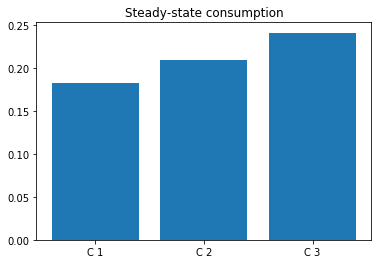

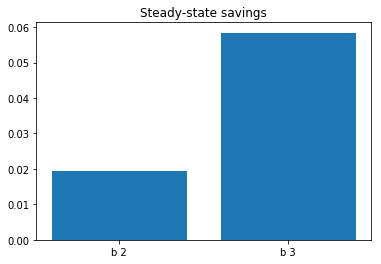

{'C_ss': 0.63289,
 'EulErr_ss': array([ 4.58641125e-10, -8.88931595e-10]),
 'K_ss': 0.07772,
 'RCerr_ss': 1.525889591895424e-06,
 'Y_ss': 0.68275,
 'b_ss': array([0.01931, 0.05841]),
 'c_ss': array([0.18241, 0.2096 , 0.24087]),
 'r_ss': 2.43314,
 'ss_time': 0.00078,
 'w_ss': 0.20172}

In [24]:
get_ss(params, bvec_guess, ss_graphs = True)

In [25]:
beta = 0.55               # 20-year discount factor
params = [beta, sigma, nvec, L, A, alpha, delta, ss_tol]

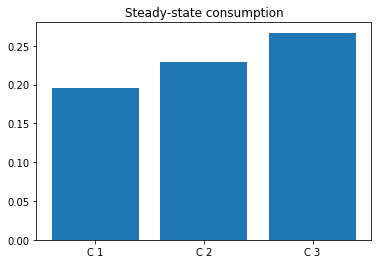

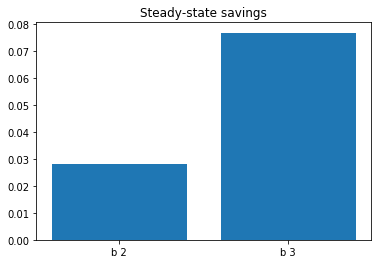

{'C_ss': 0.6913,
 'EulErr_ss': array([-6.82537689e-08, -2.50616949e-08]),
 'K_ss': 0.10505,
 'RCerr_ss': -1.0538509827295872e-06,
 'Y_ss': 0.75869,
 'b_ss': array([0.02818, 0.07687]),
 'c_ss': array([0.19598, 0.22862, 0.2667 ]),
 'r_ss': 1.88624,
 'ss_time': 0.00076,
 'w_ss': 0.22416}

In [26]:
get_ss(params, bvec_guess, ss_graphs = True)

## Exercise 2.3

Set additional parameters

In [27]:
# Set parameters
beta = 0.96**20               # 20-year discount factor
T = 25                        # Steady-state horizon
tol = 1e-9                    # tolerance
xi = 0.2
nvec = np.array([1, 1, 0.2])  # Labour supply
eul_tol = 1e-6                # tolerance for Euler errors
max_iter = 10_000
params = [beta, sigma, nvec, L, A, alpha, delta, eul_tol, max_iter]

Solve for the steady-state

In [28]:
output_ss = get_ss(params, bvec_guess)
b2bar = output_ss['b_ss'][0]
b3bar = output_ss['b_ss'][1]
b_ss = np.array([b2bar, b3bar])

In [29]:
b_ss

array([0.01931, 0.05841])

Set initial conditions

In [30]:
b21 = 0.8 * b2bar
b31 = 1.1 * b3bar
bvec_guess = np.array([b21, b31])

Guess path of K

In [31]:
K1 = b21 + b31
Kbar = b2bar + b3bar
Kpath = np.linspace(K1, Kbar, T)
Kpath = np.append(Kpath, Kbar)

Get interest rates and wages paths depending on capital path

In [32]:
def get_wr_paths(T, Kpath, Kbar, params):
    
    rpath = np.zeros(T)
    wpath = np.zeros(T)
    for t in range(T):
        rpath[t] = get_r(Kpath[t], params)
        wpath[t] = get_w(Kpath[t], params)
    rbar = get_r(Kbar, params)
    wbar = get_w(Kbar, params)
    rpath = np.append(rpath, rbar)
    wpath = np.append(wpath, wbar)
    
    return np.array([rpath, wpath])

Define function that computes the Euler Errors for b32

In [33]:
# Euler error for b32
def b32_EulErr(b32, b32_params):
    """ b32_params = (b21, b22, rpath, wpath, params)
    """
    
    b21    = b32_params[0]
    b22    = b32_params[1]
    rpath  = b32_params[2]
    wpath  = b32_params[3]
    params = b32_params[4]
    
    c1 = (1 + rpath[0]) * b21 + wpath[0] * params[2][1] - b32
    u1 = u_prime(c1, params)
    c2 = (1 + rpath[1]) * b32 + wpath[1] * params[2][2]
    u2 = u_prime(c2, params)
    
    return u1 - params[0] * (1 + rpath[1]) * u2

Define the function to get the Euler errors for $b_{32}$

In [34]:
def get_b32(b21, b22, rpath, wpath, params, bvec_guess):
    
    b32_params = [b21, b22, rpath, wpath, params]
    result = opt.root(b32_EulErr, 
                      bvec_guess[0], 
                      args = b32_params, 
                      tol = params[7])
    b32 = result.x
    b32_EulErrs = result.fun
    
    return np.array([b32, b32_EulErrs])

Define function that computes the Euler Errors for $b_{2t}$ and $b_{3t+1}$

In [35]:
# Euler error for b2t and b3tp1 collected in b
def b_EulErr(b, b_params):
    """ b = (b2t, b3tp1)
    bt_params = (t, rpath, wpath, params)
    """
    
    t      = b_params[0]
    rpath  = b_params[1]
    wpath  = b_params[2]
    params = b_params[3]
    
    c21 = wpath[t] * params[2][0] - b[0]
    u21 = u_prime(c21, params)
    c22 = (1 + rpath[t+1]) * b[0] + wpath[t+1] * params[2][1] - b[1]
    u22 = u_prime(c22, params)
    b2_EulErr = u21 - params[0] * (1 + rpath[t+1]) * u22
    
    c31 = (1 + rpath[t+1]) * b[0] + wpath[t+1] * params[2][1] - b[1]
    u31 = u_prime(c31, params)
    c32 = (1 + rpath[t+2]) * b[1] + wpath[t+2] * params[2][2]
    u32 = u_prime(c32, params)
    b3_EulErrs = u31 - params[0] * (1 + rpath[t+2]) * u32
    
    return np.array([b2_EulErr, b3_EulErrs])

Define the function to get the Euler errors for $b_{2t}$ and $b_{3t+1}$

In [36]:
def get_b(t, rpath, wpath, params, bvec_guess):
    
    b_params = [t, rpath, wpath, params]
    result = opt.root(b_EulErr, 
                      bvec_guess, 
                      args = b_params, 
                      tol = params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])

Define function to compute aggregate errors for each time path

In [37]:
def aggregate_errs(Kpath, rpath, wpath, bmat, params):
    
    L = params[2].sum()
    C = L * wpath[:-1] + (1 + rpath[:-1]) * bmat[:-1,0] - bmat[1:,0] + (1 + rpath[:-1]) * bmat[:-1,1] - bmat[1:,1]
    Y = params[4] * (Kpath[:-1]**params[5]) * L**(1 - params[5])
    
    agg_err = Y - C - Kpath[1:] + (1 - params[6]) * Kpath[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err
    

Compute time path of the $b_{2t}$ and $b_{3t}$, Euler errors and aggregate resources errors

In [38]:
def twisted_donut(T, rpath, wpath, Kpath, bvec_guess, b_ss, params):
    
    bmat = np.zeros((T+1, 2))
    bmat[0,:] = bvec_guess
    EulErrs = np.zeros((T+1, 2))
    cols = [0,1]
    for t in range(T-1):
        rows = [t+1, t+2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, 
                                                      rpath, 
                                                      wpath, 
                                                      params, 
                                                      bvec_guess)
    
    bmat[1,1], EulErrs[1,1] = get_b32(bmat[0,0], 
                                      bmat[0,1], 
                                      rpath, 
                                      wpath, 
                                      params, 
                                      bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis = 0)
    agg_errs = aggregate_errs(Kpath, rpath, wpath, bmat, params)
    
    
    return bmat, max_EulErrs, agg_errs

Compute K'

In [39]:
def Kprime(bmat, Kbar):
    
    Kp_path = bmat[:-1,:].sum(axis = 1)
    Kp_path = np.append(Kp_path, Kbar)
    
    return Kp_path

Compute TPI to get the equilibrium time path of the economy

In [51]:
def TPI(T, Kpath, Kbar, bvec_guess, b_ss, params, tol, max_iter):
    
    dist = tol + 1
    i = 0
    
    while (dist > tol) & (i < max_iter):
        i += 1
        rpath, wpath = get_wr_paths(T, Kpath, Kbar, params)
        bmat, max_EulErrs, max_agg_errs = twisted_donut(T, rpath, wpath, Kpath, bvec_guess, b_ss, params)
        Kp_path = Kprime(bmat, Kbar)
        dist = la.norm(Kp_path - Kpath, 2)
        Kpath = xi * Kp_path + (1 - xi) * Kpath
    
    print('Max absolute Euler errors for generation 2: ', max_EulErrs[0])
    print('Max absolute Euler errors for generation 3: ', max_EulErrs[1])
    print('Max absolute aggregate resources constraint error:', max_agg_errs)
    
    return Kpath, rpath, wpath

In [52]:
Kstd_path, rstd_path, wstd_path = TPI(T, Kpath, Kbar, bvec_guess, b_ss, params, tol, max_iter)

Max absolute Euler errors for generation 2:  3.160021435633098e-07
Max absolute Euler errors for generation 3:  9.312326199051313e-08
Max absolute aggregate resources constraint error: 0.019309231549849922


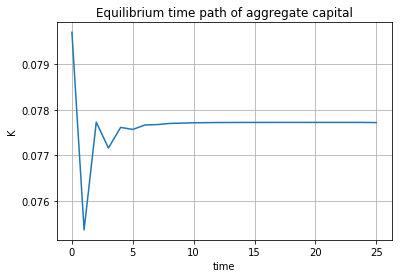

In [42]:
plt.plot(Kstd_path)
plt.title('Equilibrium time path of aggregate capital')
plt.xlabel('time')
plt.ylabel('K')
plt.grid(True)
plt.show()

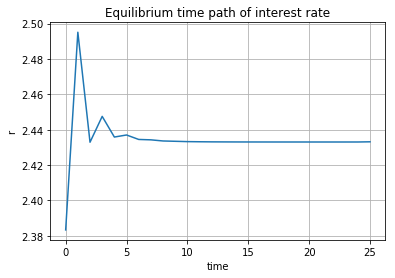

In [43]:
plt.plot(rstd_path)
plt.title('Equilibrium time path of interest rate')
plt.xlabel('time')
plt.ylabel('r')
plt.grid(True)
plt.show()

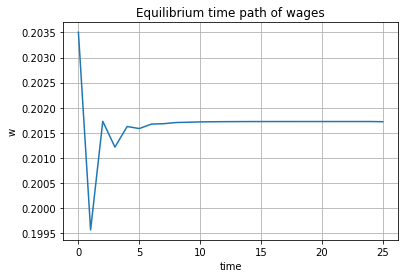

In [44]:
plt.plot(wstd_path)
plt.title('Equilibrium time path of wages')
plt.xlabel('time')
plt.ylabel('w')
plt.grid(True)
plt.show()

In [45]:
Kstd_dist = np.abs(Kstd_path - Kbar)
err = 1e-5
loc = np.where(Kstd_dist < err)[0]
print('Number of periods taken by the economy to get within 1e-5 of the steady state aggregate capital: ', loc.min())
loc_cons = np.ediff1d(loc) == 1
print('Number of periods from which the economy stays within 1e-5 of the steady state aggregate capital: ', loc[-len(loc_cons)])

Number of periods taken by the economy to get within 1e-5 of the steady state aggregate capital:  2
Number of periods from which the economy stays within 1e-5 of the steady state aggregate capital:  10
